# ***Section Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "s"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [3]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [4]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      file_names.append(msi_row.file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:16<00:00,  5.70s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [5]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [6]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [7]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [8]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
84/84 [==============================] - 22s 239ms/step - loss: 0.0865 - binary_accuracy: 0.9672 - val_loss: 0.6632 - val_binary_accuracy: 0.6517
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/100
84/84 [==============================] - 20s 237ms/step - loss: 0.0128 - binary_accuracy: 0.9958 - val_loss: 0.7157 - val_binary_accuracy: 0.6517
Epoch 3/100
84/84 [==============================] - 20s 233ms/step - loss: 0.0058 - binary_accuracy: 0.9981 - val_loss: 0.6388 - val_binary_accuracy: 0.6517
Epoch 4/100
84/84 [==============================] - 20s 239ms/step - loss: 0.0049 - binary_accuracy: 0.9984 - val_loss: 0.5036 - val_binary_accuracy: 0.6558
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 5/100
84/84 [==============================] - 20s 232ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.4081 - val_binary_acc

  5%|▍         | 1/22 [08:50<3:05:50, 530.98s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 242ms/step - loss: 0.1030 - binary_accuracy: 0.9607 - val_loss: 0.7441 - val_binary_accuracy: 0.6225
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/100
83/83 [==============================] - 21s 251ms/step - loss: 0.0152 - binary_accuracy: 0.9945 - val_loss: 0.8827 - val_binary_accuracy: 0.6225
Epoch 3/100
83/83 [==============================] - 20s 244ms/step - loss: 0.0064 - binary_accuracy: 0.9977 - val_loss: 0.9536 - val_binary_accuracy: 0.6225
Epoch 4/100
83/83 [==============================] - 21s 250ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 0.8841 - val_binary_accuracy: 0.6225
Epoch 5/100
83/83 [==============================] - 21s 249ms/step - loss: 0.0030 - binary_accuracy: 0.9989 - val_loss: 0.5212 - val_binary_accuracy: 0.6450
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

  9%|▉         | 2/22 [13:52<2:11:58, 395.95s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 246ms/step - loss: 0.1157 - binary_accuracy: 0.9562 - val_loss: 0.6586 - val_binary_accuracy: 0.6243
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/100
83/83 [==============================] - 21s 251ms/step - loss: 0.0126 - binary_accuracy: 0.9959 - val_loss: 0.6419 - val_binary_accuracy: 0.6243
Epoch 3/100
83/83 [==============================] - 22s 260ms/step - loss: 0.0076 - binary_accuracy: 0.9976 - val_loss: 0.5985 - val_binary_accuracy: 0.7036
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 4/100
83/83 [==============================] - 20s 244ms/step - loss: 0.0050 - binary_accuracy: 0.9981 - val_loss: 0.4968 - val_binary_accuracy: 0.9501
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
E

 14%|█▎        | 3/22 [21:01<2:10:11, 411.13s/it]

##############################
Epoch 1/100
84/84 [==============================] - 20s 234ms/step - loss: 0.1313 - binary_accuracy: 0.9513 - val_loss: 0.6722 - val_binary_accuracy: 0.6286
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/100
84/84 [==============================] - 21s 248ms/step - loss: 0.0132 - binary_accuracy: 0.9954 - val_loss: 0.6898 - val_binary_accuracy: 0.6286
Epoch 3/100
84/84 [==============================] - 20s 233ms/step - loss: 0.0064 - binary_accuracy: 0.9978 - val_loss: 0.7012 - val_binary_accuracy: 0.6286
Epoch 4/100
84/84 [==============================] - 21s 251ms/step - loss: 0.0035 - binary_accuracy: 0.9987 - val_loss: 0.5958 - val_binary_accuracy: 0.6286
Epoch 5/100
84/84 [==============================] - 20s 233ms/step - loss: 0.0023 - binary_accuracy: 0.9993 - val_loss: 0.4072 - val_binary_accuracy: 0.6852
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 18%|█▊        | 4/22 [26:45<1:55:23, 384.63s/it]

##############################
Epoch 1/100
84/84 [==============================] - 20s 231ms/step - loss: 0.1175 - binary_accuracy: 0.9544 - val_loss: 0.6644 - val_binary_accuracy: 0.6274
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/100
84/84 [==============================] - 21s 247ms/step - loss: 0.0103 - binary_accuracy: 0.9962 - val_loss: 0.6598 - val_binary_accuracy: 0.6274
Epoch 3/100
84/84 [==============================] - 21s 247ms/step - loss: 0.0060 - binary_accuracy: 0.9978 - val_loss: 0.6110 - val_binary_accuracy: 0.6274
Epoch 4/100
84/84 [==============================] - 21s 251ms/step - loss: 0.0042 - binary_accuracy: 0.9987 - val_loss: 0.5229 - val_binary_accuracy: 0.6330
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 5/100
84/84 [==============================] - 20s 244ms/step - loss: 0.0037 - binary_accuracy: 0.9986 - va

 23%|██▎       | 5/22 [32:25<1:44:24, 368.51s/it]

##############################
Epoch 1/100
84/84 [==============================] - 21s 241ms/step - loss: 0.1116 - binary_accuracy: 0.9562 - val_loss: 0.6632 - val_binary_accuracy: 0.6271
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/100
84/84 [==============================] - 20s 238ms/step - loss: 0.0138 - binary_accuracy: 0.9955 - val_loss: 0.6454 - val_binary_accuracy: 0.6271
Epoch 3/100
84/84 [==============================] - 21s 255ms/step - loss: 0.0065 - binary_accuracy: 0.9978 - val_loss: 0.5973 - val_binary_accuracy: 0.6279
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 4/100
84/84 [==============================] - 21s 252ms/step - loss: 0.0045 - binary_accuracy: 0.9985 - val_loss: 0.4925 - val_binary_accuracy: 0.9901
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
E

 27%|██▋       | 6/22 [38:49<1:39:40, 373.81s/it]

##############################
Epoch 1/100
79/79 [==============================] - 21s 263ms/step - loss: 0.1109 - binary_accuracy: 0.9571 - val_loss: 0.7068 - val_binary_accuracy: 0.6054
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/100
79/79 [==============================] - 20s 244ms/step - loss: 0.0115 - binary_accuracy: 0.9961 - val_loss: 0.7732 - val_binary_accuracy: 0.6054
Epoch 3/100
79/79 [==============================] - 21s 264ms/step - loss: 0.0061 - binary_accuracy: 0.9977 - val_loss: 0.7847 - val_binary_accuracy: 0.6054
Epoch 4/100
79/79 [==============================] - 21s 262ms/step - loss: 0.0054 - binary_accuracy: 0.9981 - val_loss: 0.6535 - val_binary_accuracy: 0.6054
Epoch 5/100
79/79 [==============================] - 21s 266ms/step - loss: 0.0031 - binary_accuracy: 0.9990 - val_loss: 0.5087 - val_binary_accuracy: 0.6191
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 32%|███▏      | 7/22 [46:39<1:41:19, 405.31s/it]

##############################
Epoch 1/100
84/84 [==============================] - 21s 246ms/step - loss: 0.1030 - binary_accuracy: 0.9596 - val_loss: 0.6983 - val_binary_accuracy: 0.6272
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/100
84/84 [==============================] - 21s 256ms/step - loss: 0.0131 - binary_accuracy: 0.9955 - val_loss: 0.7608 - val_binary_accuracy: 0.6272
Epoch 3/100
84/84 [==============================] - 20s 243ms/step - loss: 0.0065 - binary_accuracy: 0.9979 - val_loss: 0.7908 - val_binary_accuracy: 0.6272
Epoch 4/100
84/84 [==============================] - 20s 241ms/step - loss: 0.0048 - binary_accuracy: 0.9983 - val_loss: 0.7129 - val_binary_accuracy: 0.6272
Epoch 5/100
84/84 [==============================] - 21s 246ms/step - loss: 0.0031 - binary_accuracy: 0.9989 - val_loss: 0.3514 - val_binary_accuracy: 0.7441
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 36%|███▋      | 8/22 [52:32<1:30:40, 388.58s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 240ms/step - loss: 0.1107 - binary_accuracy: 0.9588 - val_loss: 0.6833 - val_binary_accuracy: 0.6233
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/100
83/83 [==============================] - 21s 254ms/step - loss: 0.0120 - binary_accuracy: 0.9963 - val_loss: 0.7164 - val_binary_accuracy: 0.6233
Epoch 3/100
83/83 [==============================] - 20s 239ms/step - loss: 0.0081 - binary_accuracy: 0.9969 - val_loss: 0.6428 - val_binary_accuracy: 0.6233
Epoch 4/100
83/83 [==============================] - 19s 224ms/step - loss: 0.0067 - binary_accuracy: 0.9981 - val_loss: 0.5283 - val_binary_accuracy: 0.6326
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 5/100
83/83 [==============================] - 21s 255ms/step - loss: 0.0029 - binary_accuracy: 0.9990 - 

 41%|████      | 9/22 [59:14<1:25:06, 392.82s/it]

##############################
Epoch 1/100
80/80 [==============================] - 21s 253ms/step - loss: 0.1117 - binary_accuracy: 0.9570 - val_loss: 0.6668 - val_binary_accuracy: 0.6113
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/100
80/80 [==============================] - 21s 263ms/step - loss: 0.0122 - binary_accuracy: 0.9957 - val_loss: 0.6584 - val_binary_accuracy: 0.6113
Epoch 3/100
80/80 [==============================] - 21s 262ms/step - loss: 0.0069 - binary_accuracy: 0.9979 - val_loss: 0.6147 - val_binary_accuracy: 0.6113
Epoch 4/100
80/80 [==============================] - 20s 256ms/step - loss: 0.0056 - binary_accuracy: 0.9980 - val_loss: 0.5046 - val_binary_accuracy: 0.6707
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 5/100
80/80 [==============================] - 20s 251ms/step - loss: 0.0052 - binary_accuracy: 0.9982 - 

 45%|████▌     | 10/22 [1:07:22<1:24:25, 422.14s/it]

##############################
Epoch 1/100
78/78 [==============================] - 21s 267ms/step - loss: 0.1054 - binary_accuracy: 0.9581 - val_loss: 0.7159 - val_binary_accuracy: 0.5967
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/100
78/78 [==============================] - 21s 268ms/step - loss: 0.0157 - binary_accuracy: 0.9946 - val_loss: 0.7459 - val_binary_accuracy: 0.5967
Epoch 3/100
78/78 [==============================] - 21s 265ms/step - loss: 0.0095 - binary_accuracy: 0.9971 - val_loss: 0.6700 - val_binary_accuracy: 0.5967
Epoch 4/100
78/78 [==============================] - 21s 264ms/step - loss: 0.0071 - binary_accuracy: 0.9977 - val_loss: 0.6861 - val_binary_accuracy: 0.5967
Epoch 5/100
78/78 [==============================] - 20s 261ms/step - loss: 0.0168 - binary_accuracy: 0.9948 - val_loss: 0.2977 - val_binary_accuracy: 0.9895
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 50%|█████     | 11/22 [1:12:50<1:12:07, 393.45s/it]

##############################
Epoch 1/100
82/82 [==============================] - 23s 278ms/step - loss: 0.1127 - binary_accuracy: 0.9573 - val_loss: 0.6777 - val_binary_accuracy: 0.6191
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/100
82/82 [==============================] - 24s 295ms/step - loss: 0.0119 - binary_accuracy: 0.9959 - val_loss: 0.7001 - val_binary_accuracy: 0.6191
Epoch 3/100
82/82 [==============================] - 23s 280ms/step - loss: 0.0108 - binary_accuracy: 0.9968 - val_loss: 0.6074 - val_binary_accuracy: 0.6191
Epoch 4/100
82/82 [==============================] - 23s 275ms/step - loss: 0.0055 - binary_accuracy: 0.9980 - val_loss: 0.5408 - val_binary_accuracy: 0.6235
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 5/100
82/82 [==============================] - 22s 274ms/step - loss: 0.0041 - binary_accuracy: 0.9988 - 

 55%|█████▍    | 12/22 [1:18:37<1:03:11, 379.13s/it]

##############################
Epoch 1/100
80/80 [==============================] - 20s 237ms/step - loss: 0.1135 - binary_accuracy: 0.9563 - val_loss: 0.6642 - val_binary_accuracy: 0.6078
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/100
80/80 [==============================] - 21s 260ms/step - loss: 0.0126 - binary_accuracy: 0.9959 - val_loss: 0.6467 - val_binary_accuracy: 0.6078
Epoch 3/100
80/80 [==============================] - 20s 246ms/step - loss: 0.0055 - binary_accuracy: 0.9984 - val_loss: 0.6108 - val_binary_accuracy: 0.6606
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 4/100
80/80 [==============================] - 19s 239ms/step - loss: 0.0049 - binary_accuracy: 0.9983 - val_loss: 0.5436 - val_binary_accuracy: 0.9976
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\asset

 59%|█████▉    | 13/22 [1:24:41<56:11, 374.64s/it]  

##############################
Epoch 1/100
82/82 [==============================] - 22s 255ms/step - loss: 0.0926 - binary_accuracy: 0.9649 - val_loss: 0.6956 - val_binary_accuracy: 0.6195
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/100
82/82 [==============================] - 21s 251ms/step - loss: 0.0077 - binary_accuracy: 0.9975 - val_loss: 0.7106 - val_binary_accuracy: 0.6195
Epoch 3/100
82/82 [==============================] - 20s 249ms/step - loss: 0.0054 - binary_accuracy: 0.9979 - val_loss: 0.6484 - val_binary_accuracy: 0.6195
Epoch 4/100
82/82 [==============================] - 21s 256ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 0.5426 - val_binary_accuracy: 0.6197
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 5/100
82/82 [==============================] - 21s 252ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - 

 64%|██████▎   | 14/22 [1:31:01<50:10, 376.31s/it]

##############################
Epoch 1/100
82/82 [==============================] - 21s 250ms/step - loss: 0.0999 - binary_accuracy: 0.9620 - val_loss: 0.6489 - val_binary_accuracy: 0.6675
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/100
82/82 [==============================] - 20s 240ms/step - loss: 0.0122 - binary_accuracy: 0.9961 - val_loss: 0.6721 - val_binary_accuracy: 0.6675
Epoch 3/100
82/82 [==============================] - 21s 252ms/step - loss: 0.0085 - binary_accuracy: 0.9970 - val_loss: 0.6044 - val_binary_accuracy: 0.6675
Epoch 4/100
82/82 [==============================] - 21s 261ms/step - loss: 0.0077 - binary_accuracy: 0.9975 - val_loss: 0.4380 - val_binary_accuracy: 0.8975
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 5/100
82/82 [==============================] - 21s 256ms/step - loss: 0.0052 - binary_accuracy: 0.9984 - 

 68%|██████▊   | 15/22 [1:37:58<45:18, 388.36s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 245ms/step - loss: 0.1086 - binary_accuracy: 0.9590 - val_loss: 0.6680 - val_binary_accuracy: 0.6588
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/100
83/83 [==============================] - 19s 232ms/step - loss: 0.0125 - binary_accuracy: 0.9959 - val_loss: 0.6941 - val_binary_accuracy: 0.6588
Epoch 3/100
83/83 [==============================] - 20s 246ms/step - loss: 0.0060 - binary_accuracy: 0.9980 - val_loss: 0.6533 - val_binary_accuracy: 0.6588
Epoch 4/100
83/83 [==============================] - 21s 253ms/step - loss: 0.0032 - binary_accuracy: 0.9990 - val_loss: 0.5660 - val_binary_accuracy: 0.6588
Epoch 5/100
83/83 [==============================] - 21s 257ms/step - loss: 0.0038 - binary_accuracy: 0.9987 - val_loss: 0.3296 - val_binary_accuracy: 0.7929
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 73%|███████▎  | 16/22 [1:44:09<38:18, 383.14s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 255ms/step - loss: 0.1041 - binary_accuracy: 0.9603 - val_loss: 0.6414 - val_binary_accuracy: 0.6520
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/100
84/84 [==============================] - 20s 241ms/step - loss: 0.0129 - binary_accuracy: 0.9961 - val_loss: 0.6356 - val_binary_accuracy: 0.6520
Epoch 3/100
84/84 [==============================] - 21s 253ms/step - loss: 0.0049 - binary_accuracy: 0.9985 - val_loss: 0.5921 - val_binary_accuracy: 0.6520
Epoch 4/100
84/84 [==============================] - 22s 263ms/step - loss: 0.0049 - binary_accuracy: 0.9985 - val_loss: 0.5105 - val_binary_accuracy: 0.6972
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 5/100
84/84 [==============================] - 22s 261ms/step - loss: 0.0056 - binary_accuracy: 0.9978 - 

 77%|███████▋  | 17/22 [1:51:00<32:38, 391.64s/it]

##############################
Epoch 1/100
82/82 [==============================] - 23s 276ms/step - loss: 0.1162 - binary_accuracy: 0.9542 - val_loss: 0.6498 - val_binary_accuracy: 0.6687
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/100
82/82 [==============================] - 23s 278ms/step - loss: 0.0237 - binary_accuracy: 0.9924 - val_loss: 0.6542 - val_binary_accuracy: 0.6687
Epoch 3/100
82/82 [==============================] - 21s 261ms/step - loss: 0.0071 - binary_accuracy: 0.9977 - val_loss: 0.5988 - val_binary_accuracy: 0.6687
Epoch 4/100
82/82 [==============================] - 22s 266ms/step - loss: 0.0039 - binary_accuracy: 0.9989 - val_loss: 0.5058 - val_binary_accuracy: 0.6696
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 5/100
82/82 [==============================] - 21s 253ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - 

 82%|████████▏ | 18/22 [1:57:49<26:27, 397.00s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 252ms/step - loss: 0.0728 - binary_accuracy: 0.9725 - val_loss: 0.7017 - val_binary_accuracy: 0.6133
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/100
81/81 [==============================] - 20s 249ms/step - loss: 0.0118 - binary_accuracy: 0.9957 - val_loss: 0.8268 - val_binary_accuracy: 0.6133
Epoch 3/100
81/81 [==============================] - 21s 257ms/step - loss: 0.0059 - binary_accuracy: 0.9983 - val_loss: 0.7489 - val_binary_accuracy: 0.6133
Epoch 4/100
81/81 [==============================] - 21s 261ms/step - loss: 0.0060 - binary_accuracy: 0.9981 - val_loss: 0.5093 - val_binary_accuracy: 0.6133
Epoch 5/100
81/81 [==============================] - 20s 250ms/step - loss: 0.0035 - binary_accuracy: 0.9990 - val_loss: 0.3000 - val_binary_accuracy: 0.8388
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 86%|████████▋ | 19/22 [2:03:17<18:48, 376.04s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 247ms/step - loss: 0.1269 - binary_accuracy: 0.9529 - val_loss: 0.6744 - val_binary_accuracy: 0.6744
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/100
81/81 [==============================] - 20s 248ms/step - loss: 0.0163 - binary_accuracy: 0.9953 - val_loss: 0.8247 - val_binary_accuracy: 0.6744
Epoch 3/100
81/81 [==============================] - 20s 250ms/step - loss: 0.0071 - binary_accuracy: 0.9977 - val_loss: 0.8134 - val_binary_accuracy: 0.6744
Epoch 4/100
81/81 [==============================] - 20s 244ms/step - loss: 0.0073 - binary_accuracy: 0.9979 - val_loss: 0.7945 - val_binary_accuracy: 0.6744
Epoch 5/100
81/81 [==============================] - 21s 255ms/step - loss: 0.0049 - binary_accuracy: 0.9984 - val_loss: 0.6633 - val_binary_accuracy: 0.6744
Epoch 6/100
81/81 [==============================] - 20s 245ms/ste

 91%|█████████ | 20/22 [2:09:04<12:14, 367.36s/it]

##############################
Epoch 1/100
82/82 [==============================] - 21s 248ms/step - loss: 0.1237 - binary_accuracy: 0.9528 - val_loss: 0.6372 - val_binary_accuracy: 0.6649
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/100
82/82 [==============================] - 20s 239ms/step - loss: 0.0115 - binary_accuracy: 0.9959 - val_loss: 0.6312 - val_binary_accuracy: 0.6649
Epoch 3/100
82/82 [==============================] - 21s 261ms/step - loss: 0.0088 - binary_accuracy: 0.9974 - val_loss: 0.5979 - val_binary_accuracy: 0.6649
Epoch 4/100
82/82 [==============================] - 22s 265ms/step - loss: 0.0051 - binary_accuracy: 0.9983 - val_loss: 0.4938 - val_binary_accuracy: 0.7521
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 5/100
82/82 [==============================] - 21s 252ms/step - loss: 0.0054 - binary_accuracy: 0.9982 - 

 95%|█████████▌| 21/22 [2:15:59<06:21, 381.82s/it]

##############################
Epoch 1/100
79/79 [==============================] - 21s 254ms/step - loss: 0.1201 - binary_accuracy: 0.9537 - val_loss: 0.6443 - val_binary_accuracy: 0.6920
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/100
79/79 [==============================] - 19s 242ms/step - loss: 0.0130 - binary_accuracy: 0.9955 - val_loss: 0.7276 - val_binary_accuracy: 0.6920
Epoch 3/100
79/79 [==============================] - 20s 251ms/step - loss: 0.0071 - binary_accuracy: 0.9974 - val_loss: 0.6988 - val_binary_accuracy: 0.6920
Epoch 4/100
79/79 [==============================] - 19s 243ms/step - loss: 0.0058 - binary_accuracy: 0.9980 - val_loss: 0.5937 - val_binary_accuracy: 0.6920
Epoch 5/100
79/79 [==============================] - 21s 262ms/step - loss: 0.0048 - binary_accuracy: 0.9985 - val_loss: 0.4893 - val_binary_accuracy: 0.7037
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

100%|██████████| 22/22 [2:23:22<00:00, 391.00s/it]

##############################


In [9]:
train_metrics

{2: [4.772493412019685e-06, 1.0],
 3: [0.0005385384429246187, 1.0],
 4: [2.9203920348663814e-06, 1.0],
 5: [8.327842806465924e-05, 1.0],
 6: [6.778750685043633e-05, 1.0],
 7: [2.565522663644515e-05, 1.0],
 8: [1.390020133840153e-05, 1.0],
 9: [8.970611088443547e-05, 1.0],
 10: [7.54669554225984e-06, 1.0],
 11: [2.4969674541353015e-06, 1.0],
 12: [0.0002358759375056252, 1.0],
 13: [0.00015833052748348564, 1.0],
 14: [9.68645417742664e-06, 1.0],
 15: [7.088817255862523e-06, 1.0],
 16: [0.001472360105253756, 1.0],
 18: [0.0018515469273552299, 1.0],
 19: [1.8151762560592033e-05, 1.0],
 20: [0.00010632742487359792, 1.0],
 21: [9.13204494281672e-05, 1.0],
 23: [2.2616808564634994e-05, 1.0],
 25: [8.12228063296061e-06, 1.0],
 29: [1.5273515600711107e-05, 1.0]}

In [10]:
validation_metrics

{2: [0.0007802706677466631, 0.9998122453689575],
 3: [0.0037482965271919966, 0.9992411136627197],
 4: [0.001184268039651215, 0.9994333386421204],
 5: [0.0016871669795364141, 0.9996265769004822],
 6: [0.0019062700448557734, 0.9994379878044128],
 7: [0.0014497953234240413, 0.999625027179718],
 8: [0.0011016028001904488, 0.999603271484375],
 9: [0.002321796026080847, 0.9992502331733704],
 10: [0.0017754173604771495, 0.9994321465492249],
 11: [0.0011535749072209, 0.9998045563697815],
 12: [0.0029101024847477674, 0.9991893172264099],
 13: [0.002299940213561058, 0.9996172189712524],
 14: [0.0034354764502495527, 0.9996055960655212],
 15: [0.001430477132089436, 0.9996174573898315],
 16: [0.002513633109629154, 1.0],
 18: [0.005521912593394518, 0.9992408156394958],
 19: [0.00018382066627964377, 1.0],
 20: [0.0017221622401848435, 0.9996147155761719],
 21: [0.0025374300312250853, 0.9990277886390686],
 23: [0.0051573170349001884, 0.9992225170135498],
 25: [0.0023325656075030565, 0.9996168613433838]

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [11]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

 27%|██▋       | 6/22 [00:23<01:03,  3.96s/it]

100%|██████████| 22/22 [01:40<00:00,  4.55s/it]


Next, let's get some statistics about each left out sample predictions:

In [12]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9993631244,0.9999985695,0.9999396801,0.9999165535,0.0000839006,0,1
1,3,0.9707719088,0.9998811483,0.9986617565,0.9977144003,0.0031596725,1,1
2,4,0.9823585153,1.0000000000,0.9999948740,0.9998975992,0.0009450841,1,1
3,5,0.9997256398,1.0000000000,0.9999990463,0.9999927282,0.0000212509,1,1
4,6,0.9999638796,0.9999955893,0.9999865294,0.9999860525,0.0000042503,1,1
5,7,0.9999928474,0.9999989271,0.9999977350,0.9999974966,0.0000009622,1,1
6,8,0.0039544944,0.9999980927,0.9905947447,0.9158271551,0.1801706105,1,1
7,9,0.9935670495,0.9999947548,0.9990810156,0.9989981651,0.0007660273,1,1
8,10,0.0058884919,0.9999871254,0.9998396635,0.9967944026,0.0484480001,1,1
9,11,0.9873881936,0.9999965429,0.9998476505,0.9995498061,0.0009347563,1,1


Next, let's evaluate the classification performance:

In [13]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.909
Balanced  Accuracy: 0.902
Precision: 0.929
Recall: 0.929
F1 score: 0.929


Next, let's plot the roc curve:

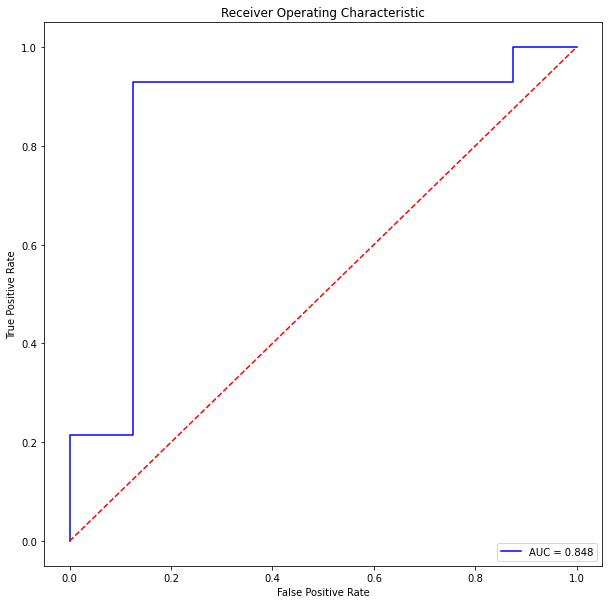

In [14]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

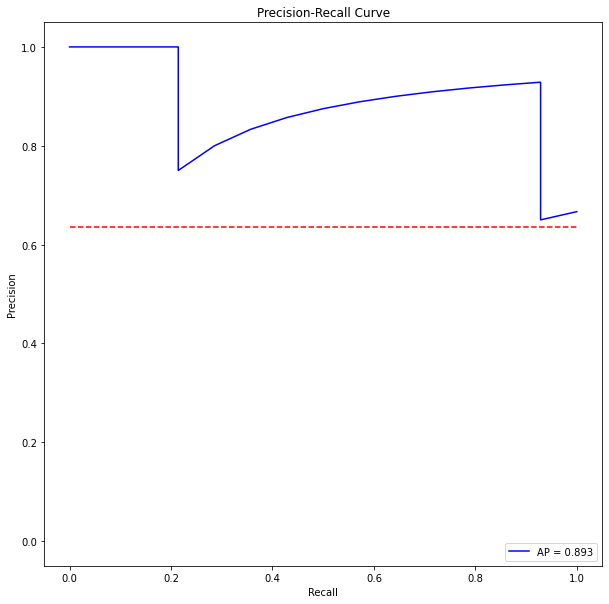

In [15]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

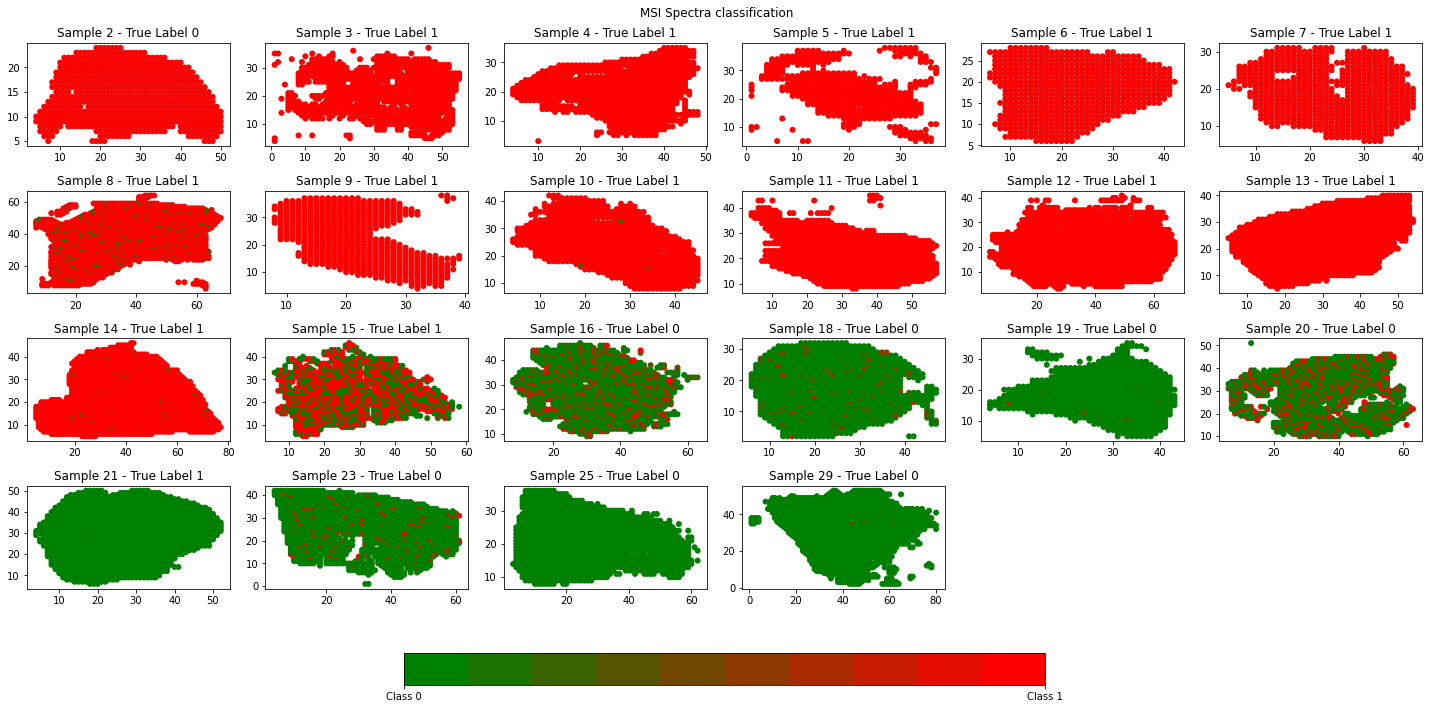

In [16]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [17]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:55<00:00,  5.27s/it]


Next, let's get some statistics about each left out sample predictions:

In [18]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9999806881,0.9999998808,0.9999994040,0.9999990463,0.0000016060,0,1
1,3,0.9757853150,0.9999355078,0.9993009567,0.9988535047,0.0014959319,1,1
2,4,0.9999990463,1.0000000000,1.0000000000,1.0000000000,0.0000000392,1,1
3,5,0.9999997616,1.0000000000,1.0000000000,1.0000000000,0.0000000417,1,1
4,6,0.9999895096,0.9999992847,0.9999985695,0.9999981523,0.0000012956,1,1
5,7,0.9999920130,0.9999991655,0.9999977350,0.9999975562,0.0000010435,1,1
6,8,0.9890795350,1.0000000000,0.9999980927,0.9999779463,0.0002735944,1,1
7,9,0.9983017445,0.9999998808,0.9999812841,0.9999669194,0.0000711928,1,1
8,10,0.9993095398,1.0000000000,0.9999506474,0.9999371171,0.0000656189,1,1
9,11,0.7356858850,1.0000000000,0.9999992847,0.9997683764,0.0070001893,1,1


Next, let's evaluate the classification performance:

In [19]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.864
Balanced  Accuracy: 0.866
Precision: 0.923
Recall: 0.857
F1 score: 0.889


Next, let's plot the roc curve:

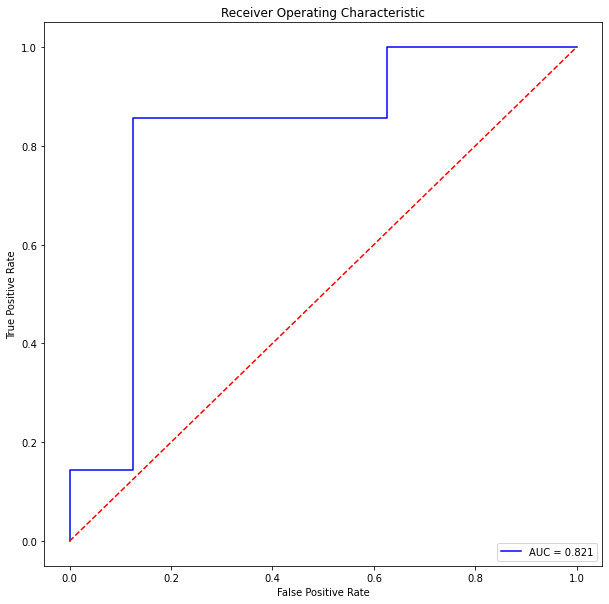

In [20]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

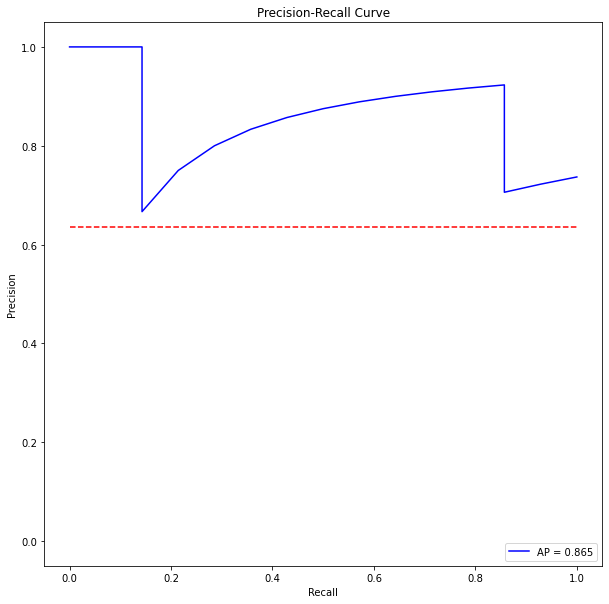

In [21]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

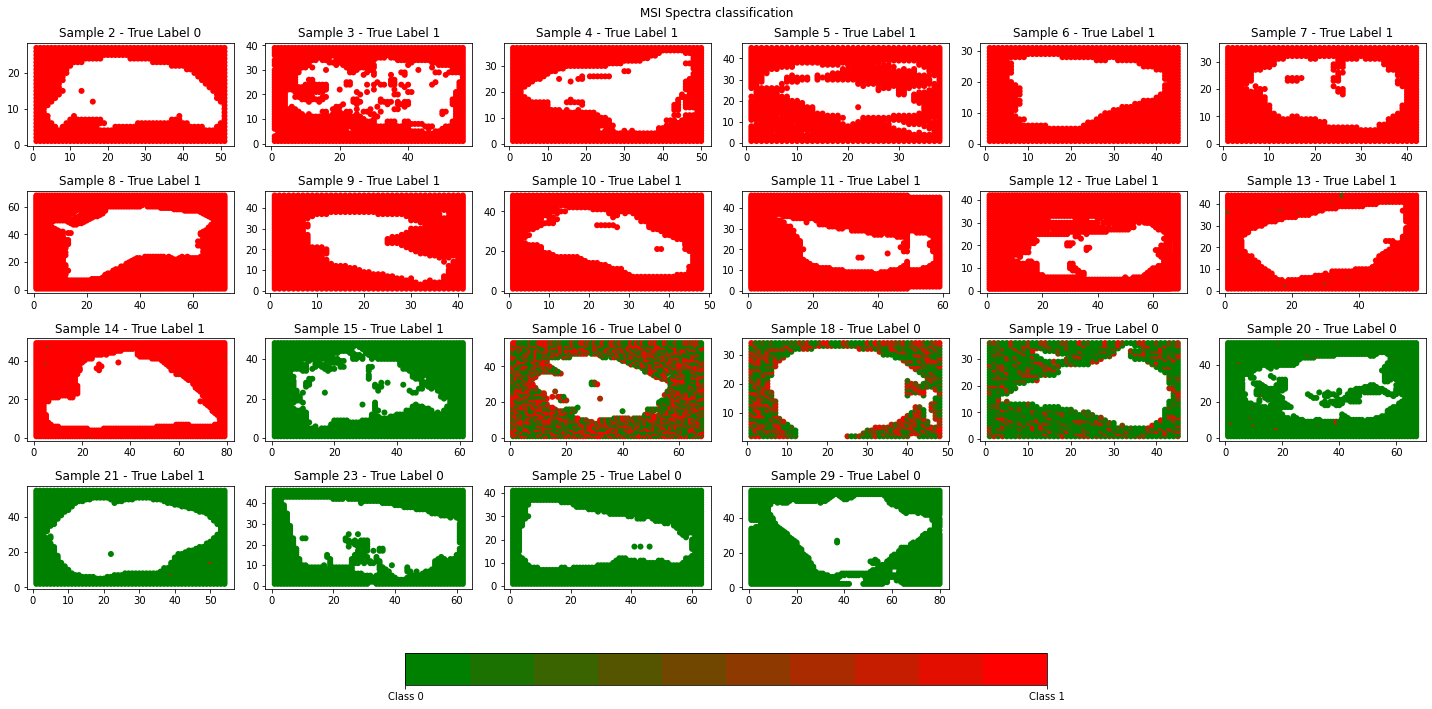

In [22]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [23]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()